In [1]:
import csv, time, torch
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt
from torch.autograd import Variable

In [4]:
hdrs = None
data = None

# parse data from song features
with open("data_old/5000_artist_song_features.csv", "r") as f:
    reader = csv.reader(f)
    all_rows = list(reader)
    hdrs = all_rows[0]
    data = all_rows[1:]

In [5]:
# join artist popularity into data set
artists = {}
hdrs.append('artist_popularity')
with open("data_old/5000_artist_list.csv", "r", encoding='ISO-8859-1') as f:
    reader = csv.reader(f); next(reader)
    for row in reader:
        artists[row[0]] = {
            "name": row[1],
            "popularity": row[2]
        }
for i in range(len(data)):
    artist_id = data[i][1]
    if artist_id in artists:
        data[i].append(artists[artist_id]["popularity"])
        
print("Number of total data rows: {}".format(len(data)))

Number of total data rows: 43797


In [6]:
data = list(filter(lambda row: len(row) == 21, data))
print("Number of valid data rows: {}".format(len(data)))

Number of valid data rows: 40134


In [7]:
data_idx = [
    'duration', 'explicit', 'danceability', 'energy', 'key', 'loudness', 
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'time_signature', 'artist_popularity'
]
x_data_idx = list(map(lambda d: hdrs.index(d), data_idx))
y_data_idx = [hdrs.index('popularity')]

# do some parsing and convert data
for i in range(len(data)):
    data[i][4] = str(int(data[i][4] == 'True'))
data = np.array(data)

# retrieve features and predicted values
y_data = data[:, y_data_idx].astype(np.float)
x_data = data[:, x_data_idx].astype(np.float)

In [8]:
# form data sets
N, F = x_data.shape
N_TRAIN = int(N * 0.9)
N_TEST = N - N_TRAIN
N_FEATURES = len(x_data[0])
x_train = Variable(torch.Tensor(x_data[:N_TRAIN]), requires_grad=False)
y_train = Variable(torch.Tensor(y_data[:N_TRAIN]), requires_grad=False)
x_test = Variable(torch.Tensor(x_data[N_TRAIN:]), requires_grad=False)
y_test = Variable(torch.Tensor(y_data[N_TRAIN:]), requires_grad=False)
print("Number of features: {}".format(N_FEATURES))
print("Split into {} train | {} test".format(N_TRAIN, N_TEST))

Number of features: 15
Split into 36120 train | 4014 test


In [7]:
# use PyTorch to perform Adam (SGD) on data set
def run_adam():
    N_STEPS, INCREMENTS, LR = 20000, 10, 0.001
    loss_fn = torch.nn.MSELoss()
    net     = torch.nn.Sequential(OrderedDict([
        ('lin1', torch.nn.Linear(N_FEATURES, 1)),
    #     ('relu', torch.nn.ReLU()),
    #     ('lin2', torch.nn.Linear(5, 1))
    ]))
    optim   = torch.optim.Adam(net.parameters(), lr=LR)

    losses = []
    last_time = time.time()
    for step in range(N_STEPS):
        pred = net.forward(x_train)
        loss = loss_fn(pred, y_train)
        if (step + 1) % (N_STEPS // INCREMENTS) == 0:
            curr_time = time.time()
            elapsed = curr_time - last_time
            last_time = curr_time
            print("Done with batch {:02d}/{:02d}, elapsed time {:04.2f}; loss is {:.2f} ".format(
                (step + 1) // (N_STEPS // INCREMENTS), INCREMENTS, elapsed, loss.data.numpy()[0]
            ))
        losses.append(loss.data.numpy()[0])
        optim.zero_grad()
        loss.backward()
        optim.step()
    pred = net.forward(x_test)
    return pred, losses

In [9]:
# use sklearn random decision trees
from sklearn.ensemble import RandomForestRegressor
def run_tree():
    regressor = RandomForestRegressor(max_depth=5, random_state=1, n_estimators=300)
    print("Fitting regressor now...")
    x_data = x_train.data.numpy()
    y_data = y_train.data.numpy().squeeze()
    regressor.fit(x_data, y_data)
    print("Done!")
    pred = regressor.predict(x_test.data.numpy())
    return Variable(torch.Tensor(pred))

Fitting regressor now...
Done!


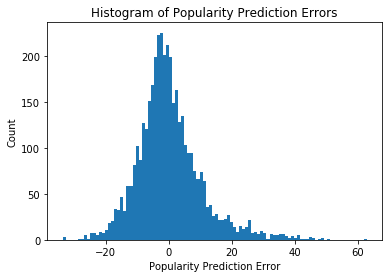

Test Avg Error: 7.50
Test RMSE: 10.35


In [10]:
def graph_losses(losses):
    plt.figure()
    plt.plot(
        list(range(1, len(losses) + 1)),
        list(map(np.log, losses))
    )
    plt.xlabel("SGD Step")
    plt.ylabel("MSE")
    plt.title("Log Popularity Prediction MSE vs. SGD Step Number")
    plt.show()
    
def calculate_mse(pred):
    pred = pred.view(4014, 1)
    errs = pred - y_test
    loss = errs.pow(2).sum()
    plt.figure()
    plt.hist(errs.data.numpy(), bins=100)
    plt.xlabel("Popularity Prediction Error")
    plt.ylabel("Count")
    plt.title("Histogram of Popularity Prediction Errors")
    plt.show()

    print("Test Avg Error: {:4.2f}".format(
        errs.abs().mean().data.numpy()[0]
    ))
    print("Test RMSE: {:4.2f}".format(
        np.sqrt(loss.data.numpy()[0] / x_test.size()[0])
    ))
    
# pred, losses = run_adam(); graph_losses(losses); calculate_mse(pred)
pred = run_tree(); calculate_mse(pred)